# Hopfield network of pattern recognition

Hopfield networks are a kind of recurrent neural network that model auto-associative memory: the ability to recall a memory from just a partial piece of that memory.

In [1]:
import numpy as np
from scipy.misc import imread, imsave
from matplotlib import pyplot as plt
import imageio
import os

%matplotlib inline

Let's load in a meme. I'm partial to ['Deal with it'](https://a1.memecaptain.com/src_thumbs/22990.jpg).

In [2]:
deal = imread('small-deal-with-it-with-text.jpg', mode="L")
print(deal.shape)
deal = deal.astype(int)

(128, 128)


In [3]:
np.unique(deal)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 18

To convert this to a 1 bit image, I convert everything darker than some threshold to black (1), and everything else to white (-1). Experimenting a bit with the particular image of the 'deal with it meme' that I have, a threshold of 80 seemed to work reasonably. The resulting image is still a bit rough around the edges, but it's recognizable.

In [4]:
bvw_threshold = 80

deal[deal <= bvw_threshold] = -1
deal[deal >  bvw_threshold] = 1
deal = -deal
deal

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ..., 
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [5]:
np.unique(deal)

array([-1,  1])

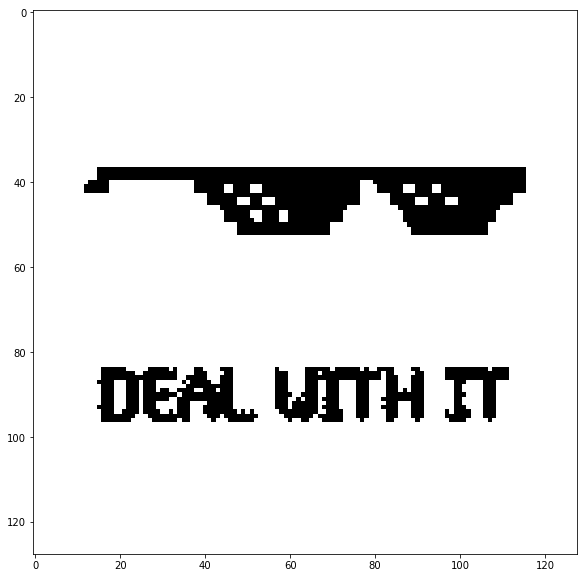

In [6]:
plt.figure(figsize=(20,10));
plt.imshow(deal, cmap='Greys', interpolation='nearest')
plt.show()

Now make weights.

In [7]:
flattened_deal = deal.flatten()
flattened_deal.shape

(16384,)

**This can take a little while if the image is large...**

In [8]:
flatlen = len(flattened_deal)
deal_weights = np.zeros(shape=(flatlen,flatlen))

deal_weights = np.outer(flattened_deal,flattened_deal) - np.identity(len(flattened_deal))
deal_weights[:5,:5]

array([[ 0.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  1.],
       [ 1.,  1.,  1.,  1.,  0.]])

Now start with a noisy version of the image. We'll just flip a certain number of random pixels on each row of the image.

In [9]:
numb_flipped = 60
noisy_deal = deal.copy()

np.random.seed(1)

for idx, row in enumerate(noisy_deal):
    for _ in range(numb_flipped):
        choice = np.random.choice(range(len(row)))
        noisy_deal[idx,choice] = -row[idx]

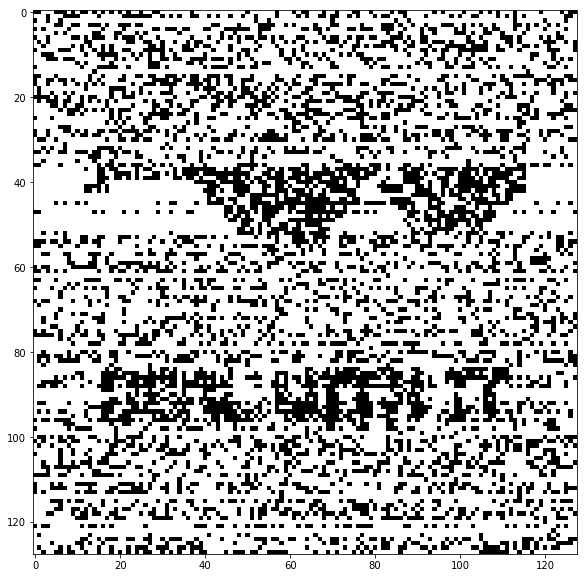

In [10]:
plt.figure(figsize=(20,10));
plt.imshow(noisy_deal, cmap='Greys', interpolation='nearest')
plt.show()

Now we can start with that, and use the weights to update it. We'll update the units asynchronously (one at a time).

In [11]:
steps = 50000
theta = 0
noisy_deal_flat = noisy_deal.flatten()

for _ in range(steps):
    unit = np.random.randint(low=0, high=(len(noisy_deal_flat)-1))
    unit_weights = deal_weights[unit,:]
    net_input = np.dot(unit_weights,noisy_deal_flat)

    noisy_deal_flat[unit] = 1 if (net_input > theta) else -1

noisy_recovered = np.reshape(a=noisy_deal_flat, newshape=(len(deal),len(deal)))

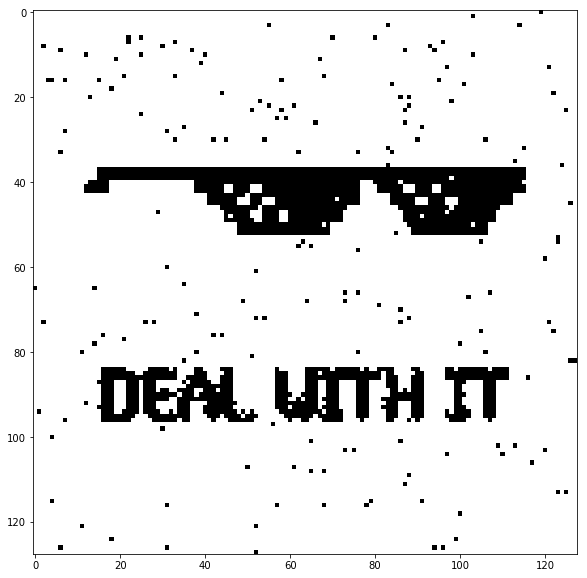

In [12]:
plt.figure(figsize=(20,10));
plt.imshow(noisy_recovered, cmap='Greys', interpolation='nearest')
plt.show()

Voila.

## Training the network on a second pattern

The cooler thing about the Hopfield networks is that they can encode multiple patterns (to a limit depending on the training regimen, and the number of units). So let's try another maymay.

I got the next meme from [here](https://68.media.tumblr.com/avatar_0f24a9a67d83_128.png), and then tweaked its levels in Mac's preview so that it'd translate nicely to a 1 bit (black or white) image.

In [13]:
woah = imread('woah.png', mode="L")
woah = woah.astype(int)
woah[woah >= 1] = 1
woah[woah < 1] = -1
woah = -woah

In [14]:
np.unique(woah)

array([-1,  1])

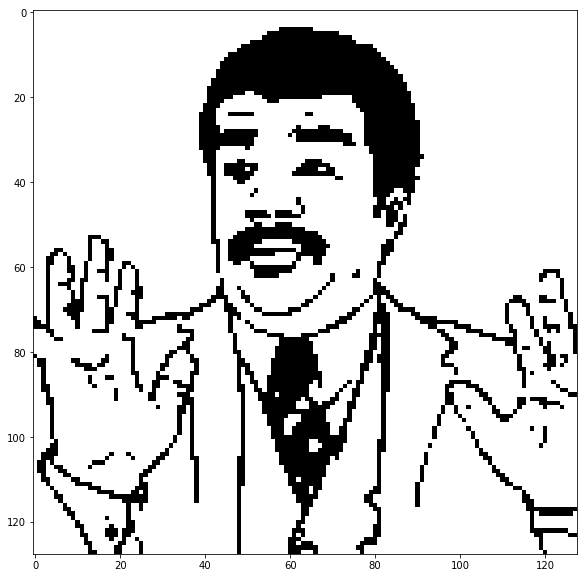

In [15]:
plt.figure(figsize=(20,10));
plt.imshow(woah, cmap='Greys', interpolation='nearest')
plt.show()

Cool. So now we make some weights for this image...

In [16]:
flattened_woah = woah.flatten()

flatlen = len(flattened_woah)
woah_weights = np.zeros(shape=(flatlen,flatlen))

woah_weights = np.outer(flattened_woah,flattened_woah) - np.identity(len(flattened_woah))
woah_weights[:5,:5]

array([[ 0.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  1.],
       [ 1.,  1.,  1.,  1.,  0.]])

...and then just average those with the weights for the 'deal with it' network. This takes a surprisingly long time (10-15 seconds).

In [17]:
average_weights = (woah_weights + deal_weights) / 2

Now, let's make a noisy Neil deGrasse Tyson, and have the network try to recover the clean, pristine NGT.

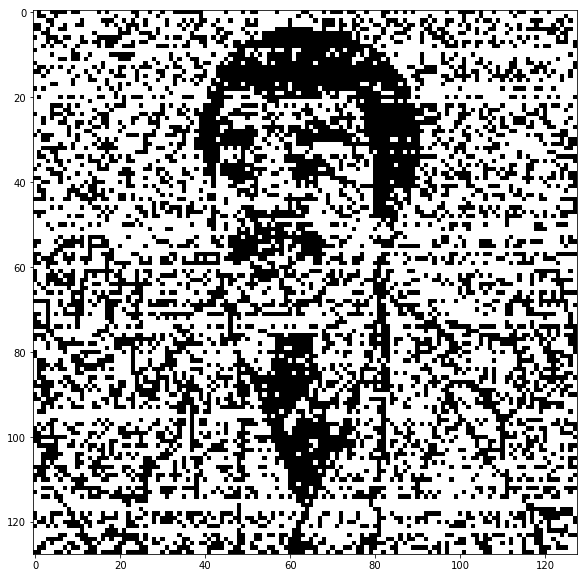

In [18]:
numb_flipped = 60

noisy_woah = woah.copy()

for idx, row in enumerate(noisy_woah):
    for _ in range(numb_flipped):
        choice = np.random.choice(range(len(row)))
        noisy_woah[idx,choice] = -row[idx]
        
plt.figure(figsize=(20,10));
plt.imshow(noisy_woah, cmap='Greys', interpolation='nearest')
plt.show()

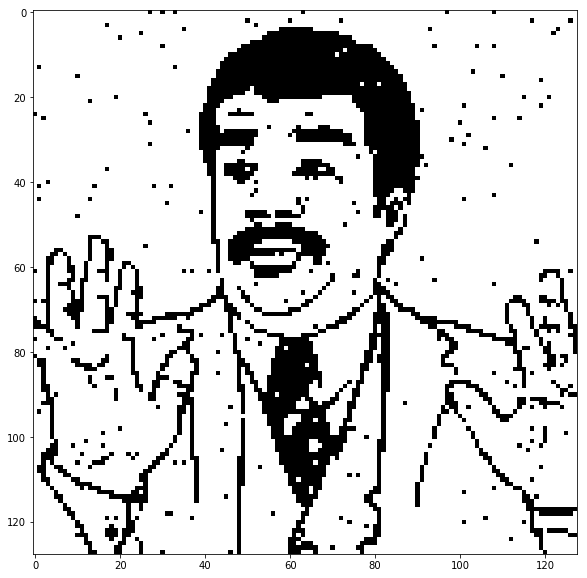

In [19]:
steps = 50000
theta = 0
noisy_woah_flat = noisy_woah.flatten()

for _ in range(steps):
    unit = np.random.randint(low=0, high=(len(noisy_woah_flat)-1))
    unit_weights = average_weights[unit,:]
    net_input = np.dot(unit_weights,noisy_woah_flat)

    noisy_woah_flat[unit] = 1 if (net_input > theta) else -1

recovered_woah = np.reshape(a=noisy_woah_flat, newshape=(len(woah),len(woah)))

plt.figure(figsize=(20,10));
plt.imshow(recovered_woah, cmap='Greys', interpolation='nearest')
plt.show()

Now let's doublecheck that the average weights also still work for the 'deal with it' image.

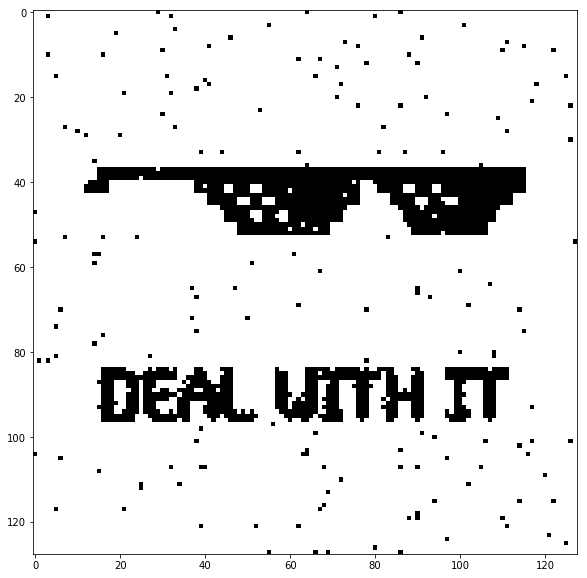

In [20]:
steps = 50000
theta = 0
noisy_deal_flat = noisy_deal.flatten()

for _ in range(steps):
    unit = np.random.randint(low=0, high=(len(noisy_deal_flat)-1))
    unit_weights = average_weights[unit,:]
    net_input = np.dot(unit_weights,noisy_deal_flat)

    noisy_deal_flat[unit] = 1 if (net_input > theta) else -1

noisy_deal_recovered = np.reshape(a=noisy_deal_flat, newshape=(len(deal),len(deal)))

plt.figure(figsize=(20,10));
plt.imshow(noisy_deal_recovered, cmap='Greys', interpolation='nearest')
plt.show()

Sweet. So *now* we can try something like feeding it a pattern that is halfway between the two patterns -- it should eventually settle into one of them! Who has greater meme strength!??!

In [21]:
deal_with_neil = (woah + deal) / 2
print(np.unique(deal_with_neil))

[-1.  0.  1.]


I could force those 0 values to -1 or 1, but that biases the pattern towards deal and neil, respectively (at least, testing suggested this -- I think because Neil has more black pixels and Deal has more white pixels). So, I'll leave them in. I *could* probably solve this by randomly setting 0's to 1 or -1, but naw.

In [22]:
#deal_with_neil[deal_with_neil == 0] = -1
#np.unique(deal_with_neil)

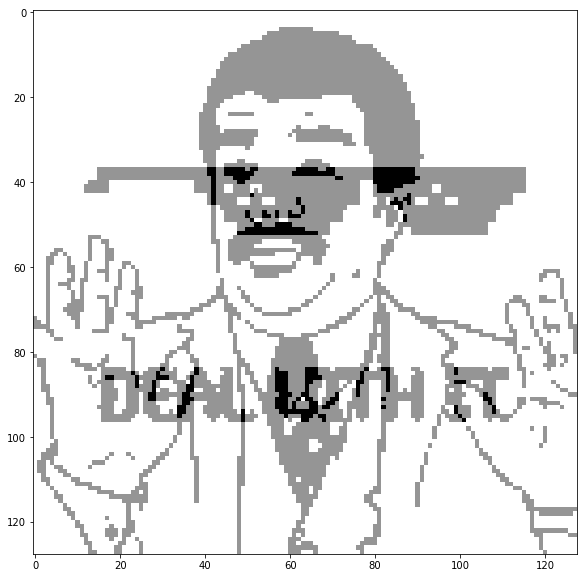

In [23]:
plt.figure(figsize=(20,10));
plt.imshow(deal_with_neil, cmap='Greys', interpolation='nearest')
plt.show()

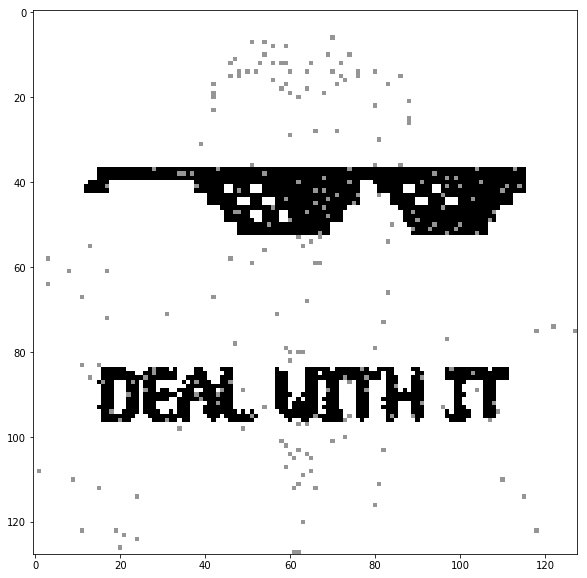

In [24]:
steps = 50000
theta = 0
deal_with_neil_flat = deal_with_neil.flatten()

for _ in range(steps):
    unit = np.random.randint(low=0, high=(len(deal_with_neil_flat)-1))
    unit_weights = average_weights[unit,:]
    net_input = np.dot(unit_weights,deal_with_neil_flat)

    deal_with_neil_flat[unit] = 1 if (net_input > theta) else -1

recovered_deal_with_neil = np.reshape(a=deal_with_neil_flat, newshape=(len(woah),len(woah)))

plt.figure(figsize=(20,10));
plt.imshow(recovered_deal_with_neil, cmap='Greys', interpolation='nearest')
plt.show()

*Assuming the cells/pixels of 0 were unaltered*, if you run that a few times, you'll notice that sometimes it settles on Neil, and sometimes it settles on Deal!!!

## Spurious patterns

Hopfield networks can also settle onto 'spurious patterns' (patterns that the network wasn't trained on). For each stored pattern `x`, `-x` is a spurious pattern. But also, any linear combination of the of the learned patterns can be a spurious pattern. So let's learn a third pattern, and then see the network stabilize on a simple combination of the three patterns.

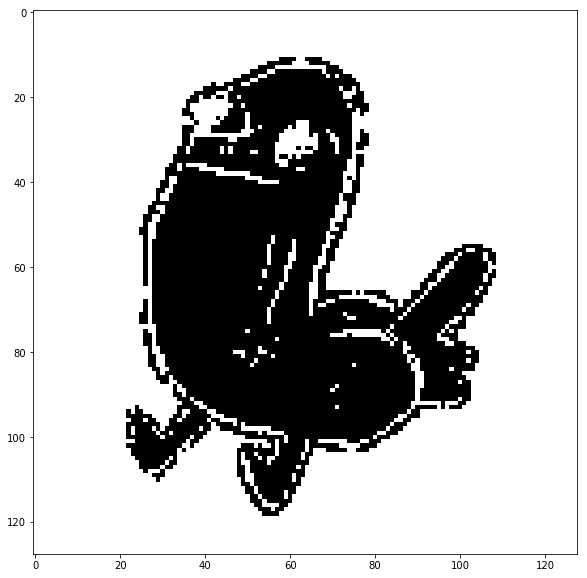

In [25]:
butt = imread('dick_butt.png', mode="L")
butt = butt.astype(int)
butt[butt >= 1] = 1
butt[butt < 1] = -1

plt.figure(figsize=(20,10));
plt.imshow(butt, cmap='Greys', interpolation='nearest')
plt.show()

In [26]:
flattened_butt = butt.flatten()

flatlen = len(flattened_butt)
butt_weights = np.zeros(shape=(flatlen,flatlen))

butt_weights = np.outer(flattened_butt,flattened_butt) - np.identity(len(flattened_butt))
butt_weights[:5,:5]

array([[ 0.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  1.],
       [ 1.,  1.,  1.,  1.,  0.]])

In [27]:
average_weights = (woah_weights + deal_weights + butt_weights) / 3

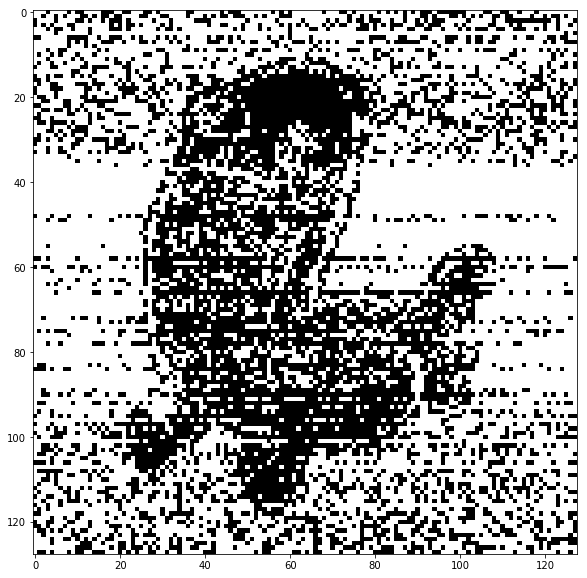

In [28]:
numb_flipped = 60

noisy_butt = butt.copy()

for idx, row in enumerate(noisy_butt):
    for _ in range(numb_flipped):
        choice = np.random.choice(range(len(row)))
        noisy_butt[idx,choice] = -row[idx]
        
plt.figure(figsize=(20,10));
plt.imshow(noisy_butt, cmap='Greys', interpolation='nearest')
plt.show()

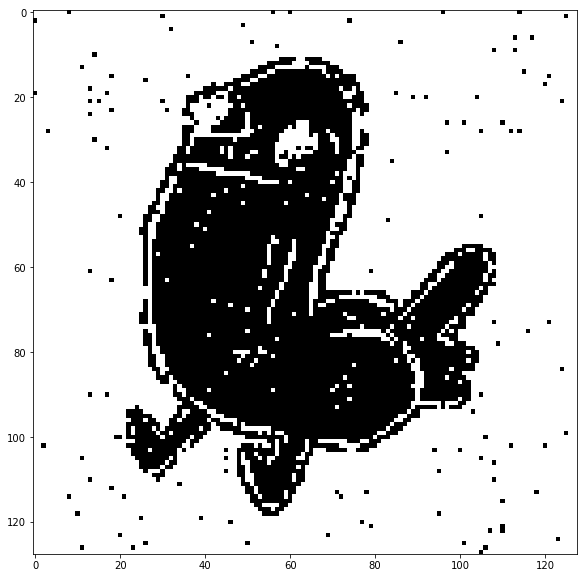

In [29]:
steps = 50000
theta = 0
noisy_butt_flat = noisy_butt.flatten()

for _ in range(steps):
    unit = np.random.randint(low=0, high=(len(noisy_butt_flat)-1))
    unit_weights = average_weights[unit,:]
    net_input = np.dot(unit_weights,noisy_butt_flat)

    noisy_butt_flat[unit] = 1 if (net_input > theta) else -1

recovered_butt = np.reshape(a=noisy_butt_flat, newshape=(len(butt),len(butt)))

plt.figure(figsize=(20,10));
plt.imshow(recovered_butt, cmap='Greys', interpolation='nearest')
plt.show()

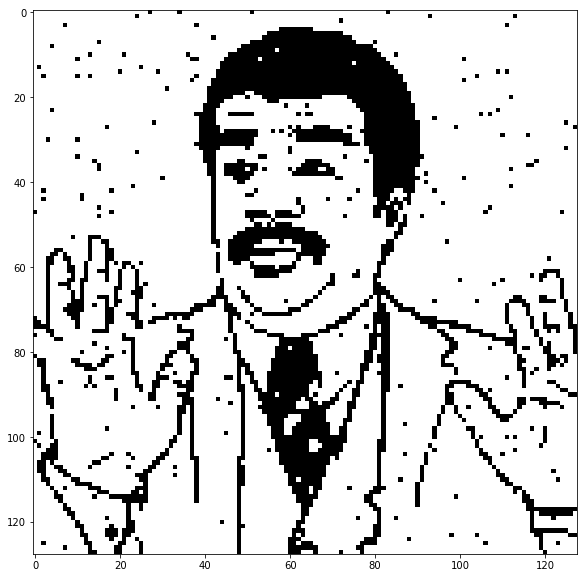

In [30]:
steps = 50000
theta = 0
noisy_woah_flat = noisy_woah.flatten()

for _a in range(steps):
    unit = np.random.randint(low=0, high=(len(noisy_woah_flat)-1))
    unit_weights = average_weights[unit,:]
    net_input = np.dot(unit_weights,noisy_woah_flat)

    noisy_woah_flat[unit] = 1 if (net_input > theta) else -1

recovered_woah = np.reshape(a=noisy_woah_flat, newshape=(len(butt),len(butt)))

plt.figure(figsize=(20,10));
plt.imshow(recovered_woah, cmap='Greys', interpolation='nearest')
plt.show()

Okay, now let's make a spurious pattern. Any linear combination will do.

In [31]:
spurious_meme = butt + deal + woah
np.unique(spurious_meme)

array([-3, -1,  1,  3])

In [32]:
spurious_meme[spurious_meme > 0] = 1
spurious_meme[spurious_meme < 0] = -1

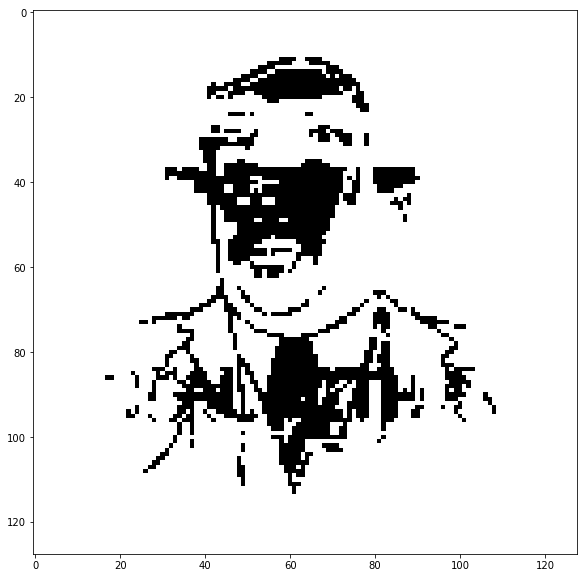

In [33]:
plt.figure(figsize=(20,10));
plt.imshow(spurious_meme, cmap='Greys', interpolation='nearest')
plt.show()

Pretty noisy. Only Neal, and kiiiiinda the Deal with It, are visible. Now make a noisy version of that combination.

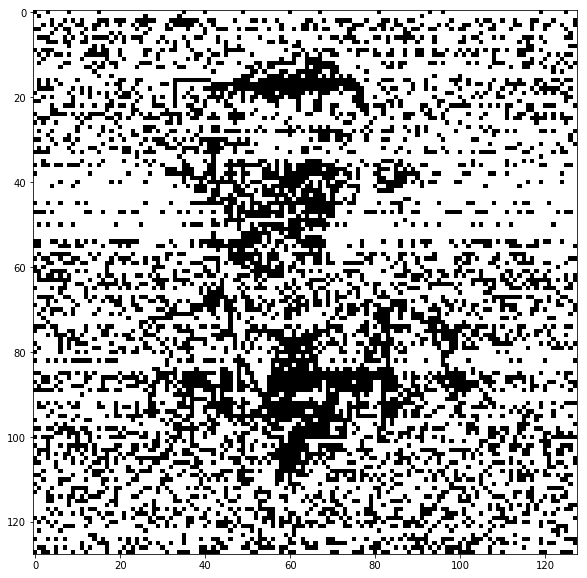

In [34]:
numb_flipped = 60

noisy_spurious_meme = spurious_meme.copy()

for idx, row in enumerate(noisy_spurious_meme):
    for _ in range(numb_flipped):
        choice = np.random.choice(range(len(row)))
        noisy_spurious_meme[idx,choice] = -row[idx]
        
plt.figure(figsize=(20,10));
plt.imshow(noisy_spurious_meme, cmap='Greys', interpolation='nearest')
plt.show()

Beautifully noisy. Can barely see anything in it. But now if we start with that, and apply the weights, it should recover the spurious pattern!

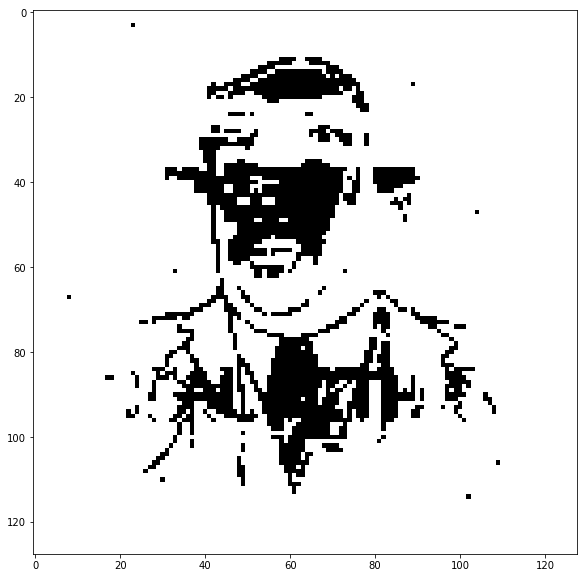

In [35]:
steps = 100000
theta = 0
noisy_spurious_meme_flat = noisy_spurious_meme.flatten()

for _ in range(steps):
    unit = np.random.randint(low=0, high=(len(noisy_spurious_meme_flat)-1))
    unit_weights = average_weights[unit,:]
    net_input = np.dot(unit_weights,noisy_spurious_meme_flat)

    noisy_spurious_meme_flat[unit] = 1 if (net_input > theta) else -1

recovered_spurious_meme = np.reshape(a=noisy_spurious_meme_flat, newshape=(len(butt),len(butt)))

plt.figure(figsize=(20,10));
plt.imshow(recovered_spurious_meme, cmap='Greys', interpolation='nearest')
plt.show()

And it sure as heck did.

## Animations

Let's make some nifty animations of the networks recovering a pattern (learned or spurious) from an input.

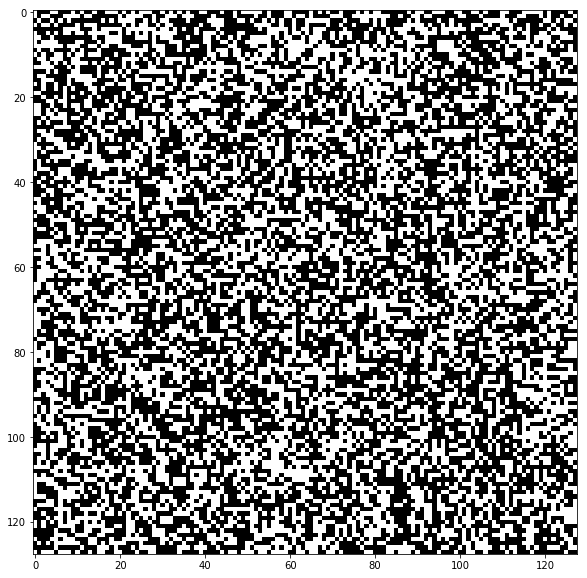

In [36]:
numb_flipped = 100

noise = woah.copy()

for idx, row in enumerate(noisy_butt):
    choices = np.random.choice(range(len(row)), numb_flipped)
    noise[idx,choices] = -noise[idx,choices]
        
plt.figure(figsize=(20,10));
plt.imshow(noise, cmap='Greys', interpolation='nearest')
plt.show()

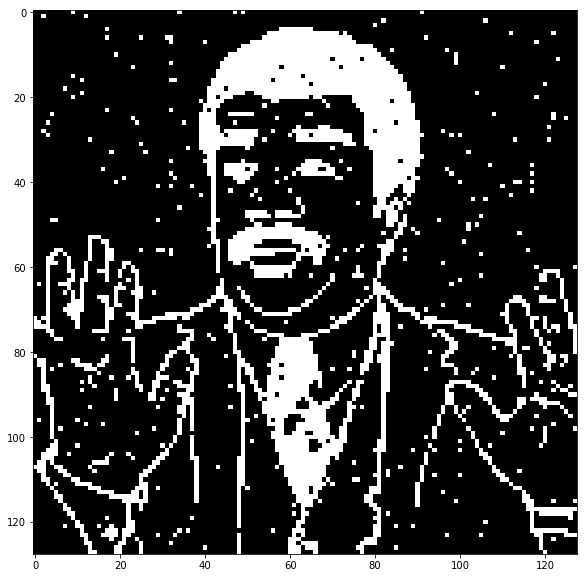

In [37]:
steps = 50000
theta = 0
noisy_meme_flat = noise.flatten()

for _a in range(steps):
    unit = np.random.randint(low=0, high=(len(noisy_meme_flat)-1))
    unit_weights = average_weights[unit,:]
    net_input = np.dot(unit_weights,noisy_meme_flat)

    noisy_meme_flat[unit] = 1 if (net_input > theta) else -1

recovered_meme = np.reshape(a=noisy_meme_flat, newshape=(len(butt),len(butt)))

plt.figure(figsize=(20,10));
plt.imshow(recovered_meme, cmap='Greys', interpolation='nearest')
plt.show()

In [38]:
steps = 50000
noisy_meme_flat = noise.flatten()
os.chdir('recovery_steps')

for step in range(steps):
    unit = np.random.randint(low=0, high=(len(noisy_meme_flat)-1))
    unit_weights = average_weights[unit,:]
    net_input = np.dot(unit_weights,noisy_meme_flat)

    noisy_meme_flat[unit] = 1 if (net_input > theta) else -1

    recovered_meme = np.reshape(a=noisy_meme_flat, newshape=(len(butt),len(butt)))
    if not (step % 1000):
        imsave('recovered_meme{:05d}.jpg'.format(step), recovered_meme)

In [39]:
filenames = [x for x in os.listdir() if x[-4:] == '.jpg']
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
os.chdir("..")
imageio.mimsave('meme_movie.gif', images, duration=0.2)

<img src="meme_movie.gif" alt="Drawing" style="width: 400px;"/>